<a href="https://colab.research.google.com/github/Jaisu-1/ResNets-Cifar10/blob/master/AlexNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Subset

from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image


if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

In [0]:
device = 'cuda'
torch.cuda.is_available()

True

In [0]:
# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.0001
BATCH_SIZE = 256
NUM_EPOCHS = 40

# Architecture
NUM_CLASSES = 10

# Other
DEVICE = "cuda:0"

In [0]:
train_indices = torch.arange(0, 48000)
valid_indices = torch.arange(48000, 50000)


train_transform = transforms.Compose([transforms.Resize((70, 70)),
                                      transforms.RandomCrop((64, 64)),
                                      transforms.ToTensor()])

test_transform = transforms.Compose([transforms.Resize((70, 70)),
                                     transforms.CenterCrop((64, 64)),
                                     transforms.ToTensor()])

train_and_valid = datasets.CIFAR10(root='data', 
                                   train=True, 
                                   transform=train_transform,
                                   download=True)

train_dataset = Subset(train_and_valid, train_indices)
valid_dataset = Subset(train_and_valid, valid_indices)
test_dataset = datasets.CIFAR10(root='data', 
                                train=False, 
                                transform=test_transform,
                                download=False)




train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE,
                          num_workers=4,
                          shuffle=True)

valid_loader = DataLoader(dataset=valid_dataset, 
                          batch_size=BATCH_SIZE,
                          num_workers=4,
                          shuffle=False)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=BATCH_SIZE,
                         num_workers=4,
                         shuffle=False)

Files already downloaded and verified


In [0]:
# Checking the dataset
print('Training Set:\n')
for images, labels in train_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    break
    
# Checking the dataset
print('\nValidation Set:')
for images, labels in valid_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    break

# Checking the dataset
print('\nTesting Set:')
for images, labels in train_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    break

Training Set:

Image batch dimensions: torch.Size([256, 3, 64, 64])
Image label dimensions: torch.Size([256])

Validation Set:
Image batch dimensions: torch.Size([256, 3, 64, 64])
Image label dimensions: torch.Size([256])

Testing Set:
Image batch dimensions: torch.Size([256, 3, 64, 64])
Image label dimensions: torch.Size([256])


In [0]:
class AlexNet(nn.Module):

    def __init__(self, num_classes):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        logits = self.classifier(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas

In [0]:
torch.manual_seed(RANDOM_SEED)

model = AlexNet(NUM_CLASSES)
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [0]:
def compute_acc(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    model.eval()
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        assert predicted_labels.size() == targets.size()
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100
    

start_time = time.time()

cost_list = []
train_acc_list, valid_acc_list = [], []


for epoch in range(NUM_EPOCHS):
    
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)
            
        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        #################################################
        ### CODE ONLY FOR LOGGING BEYOND THIS POINT
        ################################################
        cost_list.append(cost.item())
        if not batch_idx % 150:
            print (f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} | '
                   f'Batch {batch_idx:03d}/{len(train_loader):03d} |' 
                   f' Cost: {cost:.4f}')

        

    model.eval()
    with torch.set_grad_enabled(False): # save memory during inference
        
        train_acc = compute_acc(model, train_loader, device=DEVICE)
        valid_acc = compute_acc(model, valid_loader, device=DEVICE)
        
        print(f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d}\n'
              f'Train ACC: {train_acc:.2f} | Validation ACC: {valid_acc:.2f}')
        
        train_acc_list.append(train_acc)
        valid_acc_list.append(valid_acc)
        
    elapsed = (time.time() - start_time)/60
    print(f'Time elapsed: {elapsed:.2f} min')
  
elapsed = (time.time() - start_time)/60
print(f'Total Training Time: {elapsed:.2f} min')

Epoch: 001/040 | Batch 000/188 | Cost: 2.3028
Epoch: 001/040 | Batch 150/188 | Cost: 1.7150
Epoch: 001/040
Train ACC: 32.38 | Validation ACC: 31.70
Time elapsed: 0.51 min
Epoch: 002/040 | Batch 000/188 | Cost: 1.7091
Epoch: 002/040 | Batch 150/188 | Cost: 1.5775
Epoch: 002/040
Train ACC: 45.36 | Validation ACC: 45.80
Time elapsed: 1.02 min
Epoch: 003/040 | Batch 000/188 | Cost: 1.4383
Epoch: 003/040 | Batch 150/188 | Cost: 1.4720
Epoch: 003/040
Train ACC: 52.43 | Validation ACC: 51.95
Time elapsed: 1.53 min
Epoch: 004/040 | Batch 000/188 | Cost: 1.3928
Epoch: 004/040 | Batch 150/188 | Cost: 1.2750
Epoch: 004/040
Train ACC: 57.55 | Validation ACC: 57.10
Time elapsed: 2.04 min
Epoch: 005/040 | Batch 000/188 | Cost: 1.0782
Epoch: 005/040 | Batch 150/188 | Cost: 1.1286
Epoch: 005/040
Train ACC: 61.80 | Validation ACC: 61.25
Time elapsed: 2.55 min
Epoch: 006/040 | Batch 000/188 | Cost: 1.0204
Epoch: 006/040 | Batch 150/188 | Cost: 1.0620
Epoch: 006/040
Train ACC: 62.41 | Validation ACC: 61.

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
next(model.parameters()).is_cuda

True

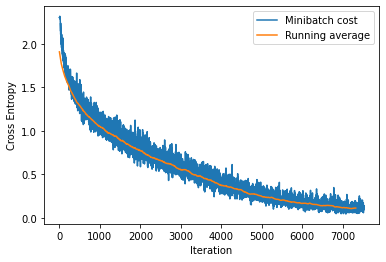

In [0]:
plt.plot(cost_list, label='Minibatch cost')
plt.plot(np.convolve(cost_list, 
                     np.ones(200,)/200, mode='valid'), 
         label='Running average')

plt.ylabel('Cross Entropy')
plt.xlabel('Iteration')
plt.legend()
plt.show()

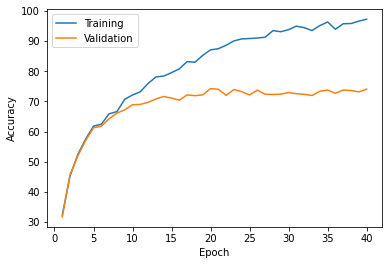

In [0]:
plt.plot(np.arange(1, NUM_EPOCHS+1), train_acc_list, label='Training')
plt.plot(np.arange(1, NUM_EPOCHS+1), valid_acc_list, label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [0]:
with torch.set_grad_enabled(False):
    test_acc = compute_acc(model=model,
                           data_loader=test_loader,
                           device=DEVICE)
    
    valid_acc = compute_acc(model=model,
                            data_loader=valid_loader,
                            device=DEVICE)
    

print(f'Validation ACC: {valid_acc:.2f}%')
print(f'Test ACC: {test_acc:.2f}%')

Validation ACC: 73.10%
Test ACC: 73.38%


In [0]:
print("!Done")

!DOne


In [0]:
from torchsummary import summary
summary(model, (3, 64, 364))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 15, 90]          23,296
              ReLU-2           [-1, 64, 15, 90]               0
         MaxPool2d-3            [-1, 64, 7, 44]               0
            Conv2d-4           [-1, 192, 7, 44]         307,392
              ReLU-5           [-1, 192, 7, 44]               0
         MaxPool2d-6           [-1, 192, 3, 21]               0
            Conv2d-7           [-1, 384, 3, 21]         663,936
              ReLU-8           [-1, 384, 3, 21]               0
            Conv2d-9           [-1, 256, 3, 21]         884,992
             ReLU-10           [-1, 256, 3, 21]               0
           Conv2d-11           [-1, 256, 3, 21]         590,080
             ReLU-12           [-1, 256, 3, 21]               0
        MaxPool2d-13           [-1, 256, 1, 10]               0
AdaptiveAvgPool2d-14            [-1, 25